In [86]:
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import shape
from tqdm import tqdm

## Requirements:
1. Tiles don't overlap with O&G regions
2. Spatial distribution of tiles based on regional O&G production amount— i.e more tiles for higher producing regions

**NOTE: did not consider seasonality distribution of selected tiles**

## Overview

This notebook outlines how the **initial** EMIT tiles were selected. Key aspects:

- Oil and gas producing regions are defined based on REDACTED field data
- We query the STAC catalog to find EMIT tile IDs that intersect with non-producing parts of each region
- Choose the tiles that are closest to the producing areas

### 1. Regional Production

All of this is copied from `tile_selection.ipynb`
- Use EI statistics to get the O&G production stats for each region
- Define how many tiles we want in our EMIT training data
    - We use 2000, copied from `tile_selection.ipynb`
- Calculate relative production weights to determine number of tiles per region

In [2]:
# copy-pasted from Statistical Review of World Energy Data
# numbers are for 2023
regional_gas_production_EJ = {
    "North America": 45.40,
    "South and Central America": 5.83,
    "Europe": 7.36,
    "CIS": 27.85,
    "Middle East": 25.66,
    "Africa": 9.13,
    "Asia Pacific": 24.91,
}
regional_oil_production_barrels = {  # thousands of barrels
    "North America": 27050,
    "South and Central America": 7368,
    "Europe": 3225,
    "CIS": 13868,
    "Middle East": 30362,
    "Africa": 7228,
    "Asia Pacific": 7275,
}
barrel_to_EJ = (
    5.86152  # GJ of energy per barrel of oil
    * 1e-9  # EJ/GJ
    * 1000  # above is given in thousands of barrels daily
    * 365  # days / year
)
regional_oil_production_EJ = {
    region: barrels * barrel_to_EJ for region, barrels in regional_oil_production_barrels.items()
}
regional_production_EJ = {
    region: regional_gas_production_EJ[region] + regional_oil_production_EJ[region]
    for region in regional_oil_production_barrels
}
regional_production_EJ

{'North America': 103.27225234,
 'South and Central America': 21.593502966400003,
 'Europe': 14.259741730000002,
 'CIS': 57.5199591664,
 'Middle East': 90.6181266376,
 'Africa': 24.5939792944,
 'Asia Pacific': 40.47453367}

In [3]:
# # get country boundaries
# !curl -L -o data/ne_110m_admin_0_countries.zip https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
# !unzip -u data/ne_110m_admin_0_countries.zip -d data/ne_110m_admin_0_countries
# !rm data/ne_110m_admin_0_countries.zip

In [4]:
world = gpd.read_file("data/ne_110m_admin_0_countries/")

# now we're going to map countries in the world dataframe
# to the EI regions
# This won't be pretty.
# Note: moved Turkey from Europe to Middle East
EI_countries_in_regions = {  # copy-pasted from spreadsheet
    "North America": ["Canada", "Mexico", "United States of America"],
    "Europe": [
        "Denmark",
        "Germany",
        "Italy",
        "Netherlands",
        "Norway",
        "Poland",
        "Romania",
        "Ukraine",
        "United Kingdom",
        "Georgia",
    ],
    "CIS": [
        "Armenia",
        "Azerbaijan",
        "Belarus",
        "Kazakhstan",
        "Kyrgyzstan",
        "Moldova",
        "Russia",
        "Tajikistan",
        "Turkmenistan",
        "Uzbekistan",
    ],
    "Middle East": [
        "Bahrain",
        "Iran",
        "Iraq",
        "Israel",
        "Kuwait",
        "Oman",
        "Qatar",
        "Saudi Arabia",
        "Syria",
        "United Arab Emirates",
        "Jordan",
        "Lebanon",
        "Turkey",
    ],
    "Asia Pacific": [
        "Australia",
        "Bangladesh",
        "Brunei",
        "China",
        "India",
        "Indonesia",
        "Malaysia",
        "Myanmar",
        "Pakistan",
        "Thailand",
        "Vietnam",
    ],
}

world["EI_region"] = world["CONTINENT"].map(
    {
        "Africa": "Africa",
        "Asia": "Asia Pacific",
        "Europe": "Europe",
        "North America": "North America",
        "South America": "South and Central America",
        "Oceania": "Asia Pacific",
        "Seven seas (open ocean)": "",
        "Antarctica": "",
    }
)

world.loc[world["SUBREGION"] == "Central America", "EI_region"] = "South and Central America"
world.loc[world["REGION_WB"] == "Middle East & North Africa", "EI_region"] = "Middle East"
world.loc[world["CONTINENT"] == "Africa", "EI_region"] = "Africa"
EI_country_to_region_map = {
    country: region for (region, country_list) in EI_countries_in_regions.items() for country in country_list
}
# check all EI countries are present in the world dataframe
world_countries_set = set(world.SOVEREIGNT)
for country in EI_country_to_region_map:
    if country == "Bahrain":
        # Bahrain is missing but it's tiny,
        # so let's ignore that
        continue
    world_countries_set.remove(country)  # this raises a KeyError if not present
EI_mapped_countries = world.SOVEREIGNT.map(EI_country_to_region_map)
world["EI_region"] = world.EI_region.where(EI_mapped_countries.isnull(), EI_mapped_countries)

world.EI_region.value_counts()

EI_region
Africa                       51
Europe                       39
Asia Pacific                 32
South and Central America    19
Middle East                  14
North America                10
CIS                          10
                              2
Name: count, dtype: int64

In [5]:
EI_geometries = world.dissolve("EI_region")

In [65]:
total_tiles = 2000
world_production = sum(regional_production_EJ.values())
num_tiles_by_region = {
    region: round(total_tiles * prod / world_production) for (region, prod) in regional_production_EJ.items()
}
# the Middle East produces a lot of O&G and isn't that large, so we cap the number of tiles at 400
num_tiles_by_region["Middle East"] = min(num_tiles_by_region["Middle East"], 400)
# if we need more tiles, add them in North America
if sum(num_tiles_by_region.values()) < total_tiles:
    num_tiles_by_region["North America"] += total_tiles - sum(num_tiles_by_region.values())
# if we have too many tiles, remove some in Europe
elif sum(num_tiles_by_region.values()) > total_tiles:
    num_tiles_by_region["Europe"] += total_tiles - sum(num_tiles_by_region.values())

num_training_tiles_by_region = num_tiles_by_region
num_training_tiles_by_region

{'North America': 699,
 'South and Central America': 123,
 'Europe': 81,
 'CIS': 327,
 'Middle East': 400,
 'Africa': 140,
 'Asia Pacific': 230}

In [64]:
total_tiles = 50
world_production = sum(regional_production_EJ.values())
num_tiles_by_region = {
    region: round(total_tiles * prod / world_production) for (region, prod) in regional_production_EJ.items()
}
# the Middle East produces a lot of O&G and isn't that large, so we cap the number of tiles at 400
num_tiles_by_region["Middle East"] = min(num_tiles_by_region["Middle East"], 400)
# if we need more tiles, add them in North America
if sum(num_tiles_by_region.values()) < total_tiles:
    num_tiles_by_region["North America"] += total_tiles - sum(num_tiles_by_region.values())
# if we have too many tiles, remove some in Europe
elif sum(num_tiles_by_region.values()) > total_tiles:
    num_tiles_by_region["Europe"] += total_tiles - sum(num_tiles_by_region.values())

num_validation_tiles_per_cloud_bucket_by_region = num_tiles_by_region
num_validation_tiles_per_cloud_bucket_by_region

{'North America': 15,
 'South and Central America': 3,
 'Europe': 2,
 'CIS': 8,
 'Middle East': 13,
 'Africa': 3,
 'Asia Pacific': 6}

### 2. Define Producing and Non Producing geometries

In [ ]:
producing_union = # Union of all producing areas, TODO: Insert as we can't share the one we were using
producing_by_region = EI_geometries.intersection(producing_union)
non_producing_by_region = EI_geometries.geometry.difference(producing_union)

<Axes: >

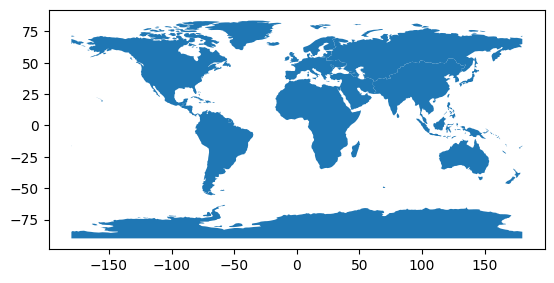

In [10]:
EI_geometries.plot()

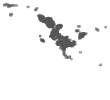

In [48]:
producing_by_region.loc["North America"]

<Axes: >

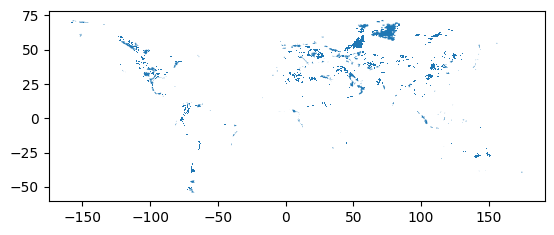

In [11]:
producing_by_region.plot()

<Axes: >

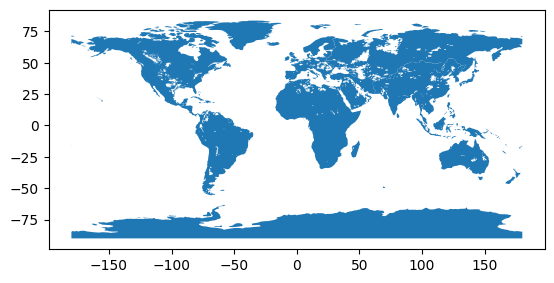

In [12]:
non_producing_by_region.plot()

### 3. Tile Selection Strategy

In [93]:
def clip_bbox(bbox):
    """Clip bbox to valid coordinate ranges"""
    minx, miny, maxx, maxy = bbox
    return (
        max(-180, min(180, minx)),  # longitude must be between -180 and 180
        max(-90, min(90, miny)),  # latitude must be between -90 and 90
        max(-180, min(180, maxx)),
        max(-90, min(90, maxy)),
    )


#######################################
##### SELECTING TRAINING TILES ########
#######################################


def fetch_training_items_for_region(catalog, region_geometry):
    """Fetch training items from the STAC catalog for a specific region."""
    bbox = clip_bbox(region_geometry.bounds)
    query = catalog.search(
        collections=["EMITL1BRAD_001"],
        bbox=bbox,
        datetime="2023",  # NOTE: our tiles are from 2023
        query=["eo:cloud_cover<20"],  # NOTE: training tile cloud coverage max
    )

    data = []
    for item in tqdm(query.items(), desc="Creating STAC gdf"):
        emit_id = item.id
        geometry = shape(item.geometry)
        data.append({"emit_id": emit_id, "geometry": geometry})

    return gpd.GeoDataFrame(data, crs="EPSG:4326")


def x_intersects_any_in_y(x: gpd.GeoSeries, y: gpd.GeoSeries):
    """Checks for intersections and returns distances."""
    if len(y) == 0:
        return np.zeros(len(x), dtype=bool), np.full(len(x), np.inf)
    matches, distances = y.sindex.nearest(x, return_all=False, return_distance=True)
    return distances == 0, distances


def process_region(region_name, gdf, producing_by_region, total_tiles):
    """
    Process a single region to select rows near producing areas but not intersecting.

    Parameters:
        region_name: Name of the region (e.g., 'North America', based on EI geometries)
        gdf: GeoDataFrame of pystac tiles
        producing_by_region: GeoDataFrame of producing areas
        total_tiles: Total number of tiles to select

    Returns:
        GeoDataFrame of selected tiles
    """
    # Get producing areas and buffer
    producing_areas = producing_by_region.loc[[region_name]]
    tiles_intersects_producing, distances_to_producing = x_intersects_any_in_y(gdf.geometry, producing_areas.geometry)

    # Filter out intersecting rows
    non_intersecting = ~tiles_intersects_producing
    gdf["distance_to_producing"] = distances_to_producing

    # Sort by distance and select top tiles
    near_tiles_sorted = gdf[non_intersecting].sort_values(by="distance_to_producing")
    selected_tiles = near_tiles_sorted.head(total_tiles)

    return selected_tiles


#######################################
##### SELECTING VALIDATION TILES ######
#######################################


def fetch_validation_items_for_region(catalog, region_geometry, cloud_min, cloud_max):
    """Fetch validation items from the STAC catalog for a specific region."""
    bbox = clip_bbox(region_geometry.bounds)
    query = catalog.search(
        collections=["EMITL1BRAD_001"],
        bbox=bbox,
        datetime="2023",  # Validation tiles are also from 2023
        query={"eo:cloud_cover": {"gte": cloud_min, "lt": cloud_max}},
    )

    data = []
    for item in tqdm(query.items(), desc="Creating STAC gdf for validation"):
        emit_id = item.id
        geometry = shape(item.geometry)
        data.append({"emit_id": emit_id, "geometry": geometry})

    return gpd.GeoDataFrame(data, crs="EPSG:4326")


def process_validation_region(region_name, validation_gdf, training_gdf, producing_by_region, total_validation_tiles):
    """
    Process a single region to select validation tiles near producing areas but not intersecting and avoiding training tiles.

    Parameters:
        region_name: Name of the region (e.g., 'North America', based on EI geometries)
        validation_gdf: GeoDataFrame of pystac validation tiles
        training_gdf: GeoDataFrame of training tiles to exclude
        producing_by_region: GeoDataFrame of producing areas
        total_validation_tiles: Total number of validation tiles to select

    Returns:
        GeoDataFrame of selected validation tiles
    """
    # Exclude items already used in training
    validation_gdf = validation_gdf[~validation_gdf["emit_id"].isin(training_gdf["emit_id"])]

    # Get producing areas and buffer
    producing_areas = producing_by_region.loc[[region_name]]
    tiles_intersects_producing, distances_to_producing = x_intersects_any_in_y(
        validation_gdf.geometry, producing_areas.geometry
    )

    validation_gdf["distance_to_producing"] = distances_to_producing

    # Exclude intersecting rows
    non_intersecting = ~tiles_intersects_producing

    # Sort by distance and select top validation tiles
    near_tiles_sorted = validation_gdf[non_intersecting].sort_values(by="distance_to_producing")
    selected_validation_tiles = near_tiles_sorted.head(total_validation_tiles)

    return selected_validation_tiles


#######################################
########## PLOTTING TILES #############
#######################################


# Plot the tiles and producing regions
def plot_region_tiles(selected_tiles, cloud_bucket_tiles, producing_region, region_name):
    """
    Plot training tiles, validation tiles, and producing regions for a region.

    Parameters:
        selected_tiles: GeoDataFrame of training tiles
        cloud_bucket_tiles: Dictionary of GeoDataFrames for cloud buckets
        producing_region: GeoDataFrame of producing regions
        region_name: Name of the region (e.g., 'North America')
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot producing regions
    producing_region.loc[[region_name]].plot(ax=ax, color="red", alpha=0.5, label="Producing Region")

    # Plot training tiles
    selected_tiles.plot(ax=ax, color="blue", alpha=0.6, label="Training Tiles")

    # Plot validation tiles for each cloud bucket
    colors = ["green", "orange", "purple"]  # Define colors for cloud buckets
    for i, (bucket_name, tiles) in enumerate(cloud_bucket_tiles.items()):
        tiles.plot(ax=ax, color=colors[i], alpha=0.6, label=f"Validation {bucket_name}")

    # Manually create legend
    legend_handles = [
        mpatches.Patch(color="red", alpha=0.5, label="Producing Region"),
        mpatches.Patch(color="blue", alpha=0.6, label="Training Tiles"),
        mpatches.Patch(color="green", alpha=0.6, label="Validation cloud_bucket_1"),
        mpatches.Patch(color="orange", alpha=0.6, label="Validation cloud_bucket_20"),
        mpatches.Patch(color="purple", alpha=0.6, label="Validation cloud_bucket_50"),
    ]
    plt.legend(handles=legend_handles, loc="upper right")

    # Add labels and grid
    plt.title(f"{region_name}: Training and Validation Tiles")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

In [92]:
%%time

catalog = Client.open("https://cmr.earthdata.nasa.gov/stac/LPCLOUD")

regions = ["North America", "South and Central America", "Europe", "CIS", "Middle East", "Africa", "Asia Pacific"]
training_tiles_by_region = {}
validation_tiles_by_region = {}

for region_name in regions:
    print(f"Gathering tiles for {region_name}")

    # Fetch items for the region
    region_geometry = EI_geometries.loc[region_name].geometry
    gdf = fetch_training_items_for_region(catalog, region_geometry)

    # Process the region to select tiles
    selected_tiles = process_region(region_name, gdf, producing_by_region, num_training_tiles_by_region[region_name])

    training_tiles_by_region[region_name] = selected_tiles

    # Define cloud buckets
    cloud_buckets = {"cloud_bucket_1": (0, 1), "cloud_bucket_20": (1, 20), "cloud_bucket_50": (20, 50)}

    cloud_bucket_tiles = {}

    # Iterate through each cloud bucket
    for bucket_name, (cloud_min, cloud_max) in cloud_buckets.items():
        print(f"Processing {bucket_name}...")

        # Fetch items for the region
        validation_gdf = fetch_validation_items_for_region(catalog, region_geometry, cloud_min, cloud_max)

        # Process the region to select validation tiles
        selected_validation_tiles = process_validation_region(
            region_name,
            validation_gdf,
            selected_tiles,
            producing_by_region,
            num_validation_tiles_per_cloud_bucket_by_region[region_name],
        )
        cloud_bucket_tiles[bucket_name] = selected_validation_tiles

    validation_tiles_by_region[region_name] = cloud_bucket_tiles

Gathering tiles for North America


1680it [02:54,  9.61it/s]


Processing cloud_bucket_1...


Creating STAC gdf for validation: 310it [00:17, 17.84it/s]
/anaconda/envs/methane-cv/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Processing cloud_bucket_20...


Creating STAC gdf for validation: 1565it [01:39, 15.79it/s]
/anaconda/envs/methane-cv/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Processing cloud_bucket_50...


Creating STAC gdf for validation: 1050it [00:58, 17.97it/s]
/anaconda/envs/methane-cv/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Gathering tiles for South and Central America


1126it [01:07, 16.77it/s]


Processing cloud_bucket_1...


Creating STAC gdf for validation: 230it [00:13, 16.79it/s]
/anaconda/envs/methane-cv/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Processing cloud_bucket_20...


Creating STAC gdf for validation: 1020it [01:04, 15.73it/s]
/anaconda/envs/methane-cv/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Processing cloud_bucket_50...


Creating STAC gdf for validation: 718it [00:45, 15.79it/s]
/anaconda/envs/methane-cv/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Gathering tiles for Europe


10488it [09:31, 18.34it/s]


Processing cloud_bucket_1...


Creating STAC gdf for validation: 4114it [03:32, 19.38it/s]
/anaconda/envs/methane-cv/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Processing cloud_bucket_20...


Creating STAC gdf for validation: 7701it [06:50, 18.77it/s]
/anaconda/envs/methane-cv/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Processing cloud_bucket_50...


Creating STAC gdf for validation: 5000it [05:43, 14.57it/s]
/anaconda/envs/methane-cv/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Gathering tiles for CIS


0it [00:00, ?it/s]


APIError: {"errors":["BBOX must be in the form of 'bbox=swLon,swLat,neLon,neLat' with valid latitude and longitude."]}

### Save csvs

In [101]:
df = pd.DataFrame(
    [
        {"region": region, "emit_id": emit_id}
        for region, gdf in training_tiles_by_region.items()
        for emit_id in gdf["emit_id"]
    ]
)
df.drop_duplicates(subset=["emit_id"], inplace=True)

# Save to CSV
df.to_csv(
    "/home/azureuser/monorepo-new/methane-cv/src/data/no_methane_tiles/emit/csv_files/initial_tiles.csv", index=False
)

In [109]:
cloud_cover_ranges = {"cloud_bucket_1": (0.0, 0.01), "cloud_bucket_20": (0.01, 0.2), "cloud_bucket_50": (0.2, 0.5)}

# Flatten the data into a list of rows
rows = []
for region, buckets in validation_tiles_by_region.items():
    for bucket, gdf in buckets.items():
        cloud_min, cloud_max = cloud_cover_ranges[bucket]
        for emit_id in gdf["emit_id"]:
            rows.append(
                {"region": region, "emit_id": emit_id, "cloud_cover_min": cloud_min, "cloud_cover_max": cloud_max}
            )
val_df = pd.DataFrame(rows)
val_df.drop_duplicates(subset=["emit_id"], inplace=True)
val_df.to_csv(
    "/home/azureuser/monorepo-new/methane-cv/src/data/no_methane_tiles/emit/csv_files/final_validation_set.csv",
    index=False,
)

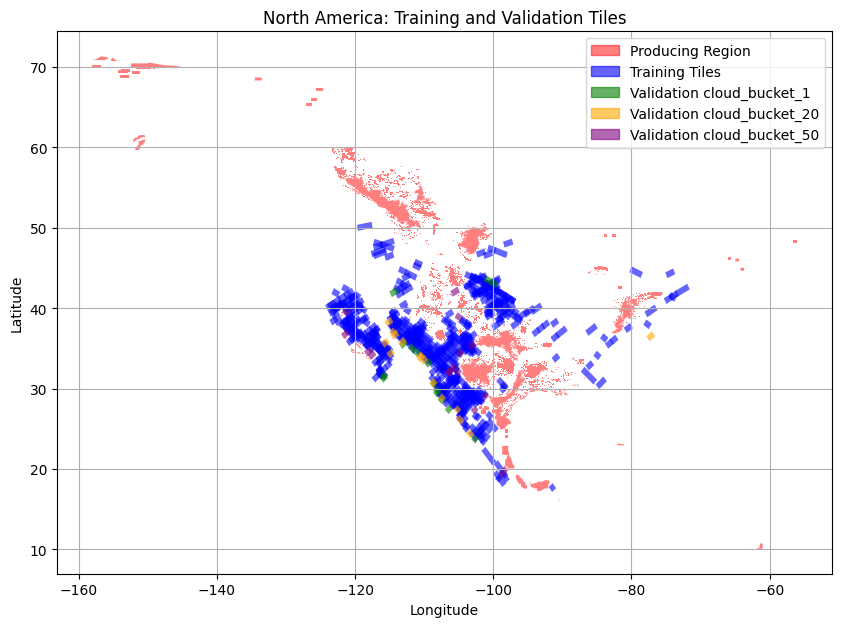

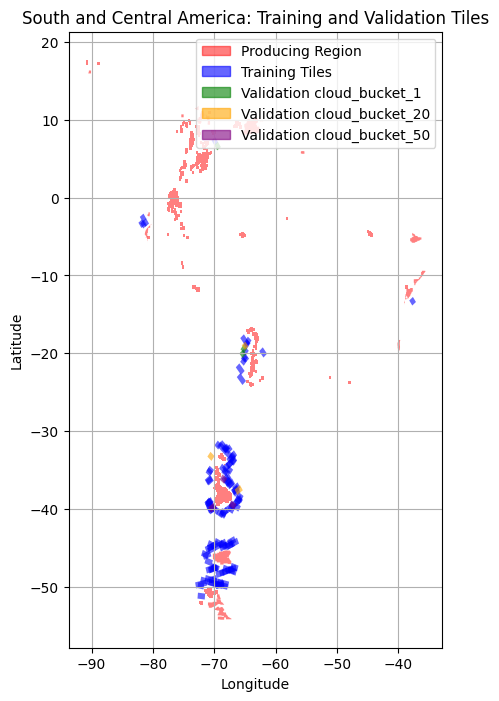

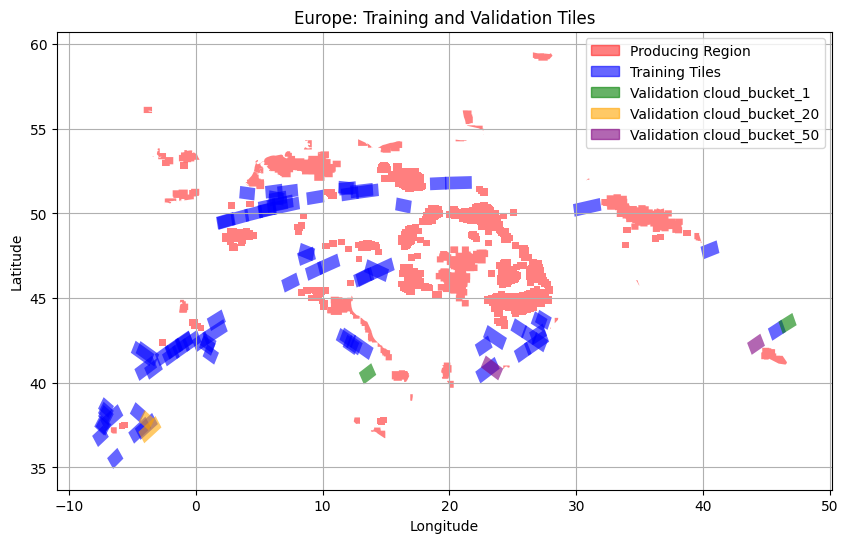

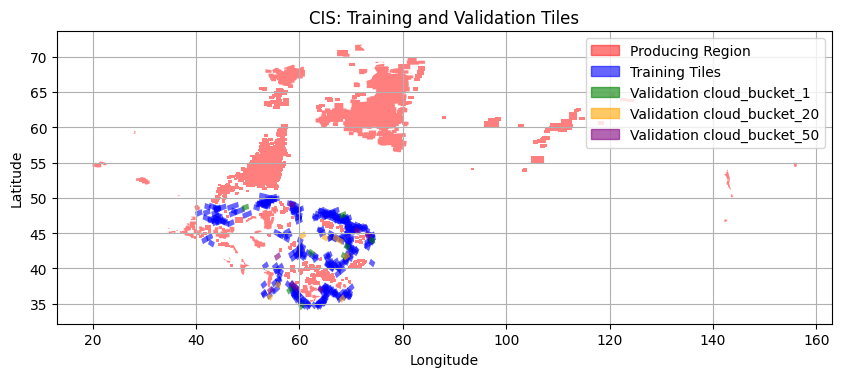

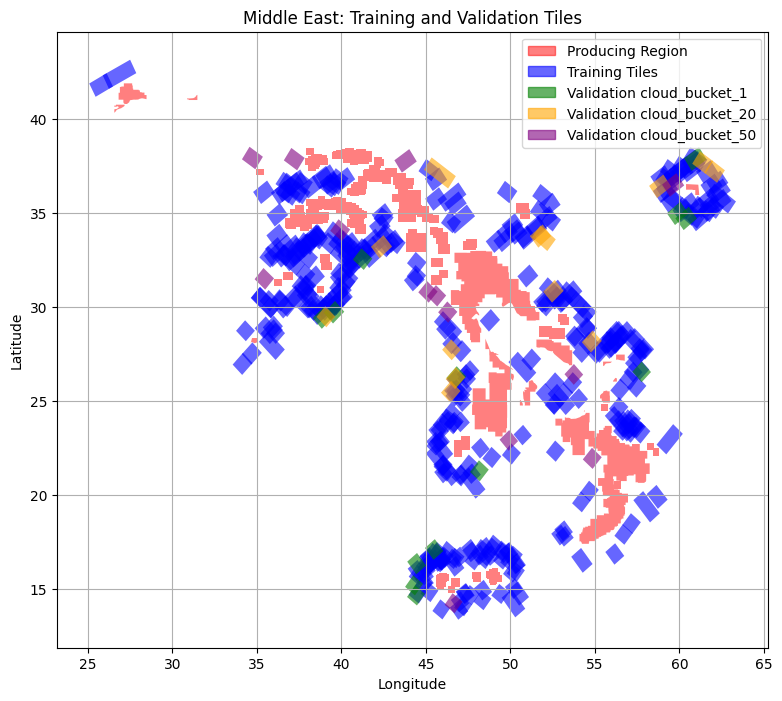

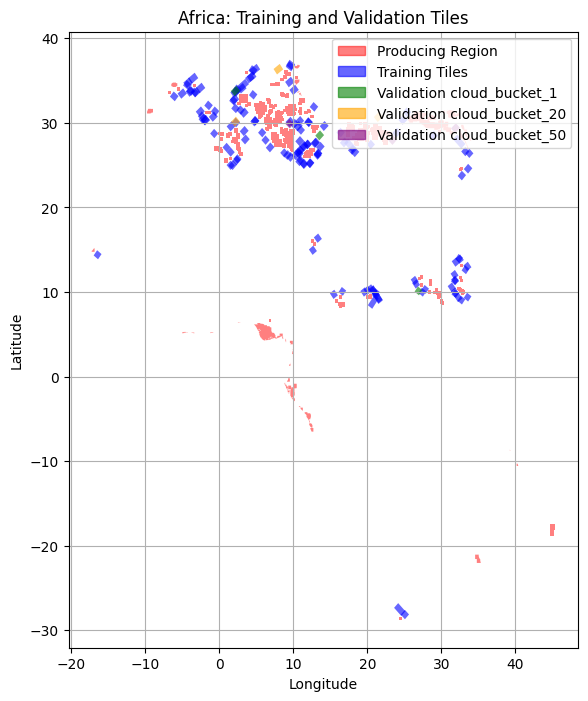

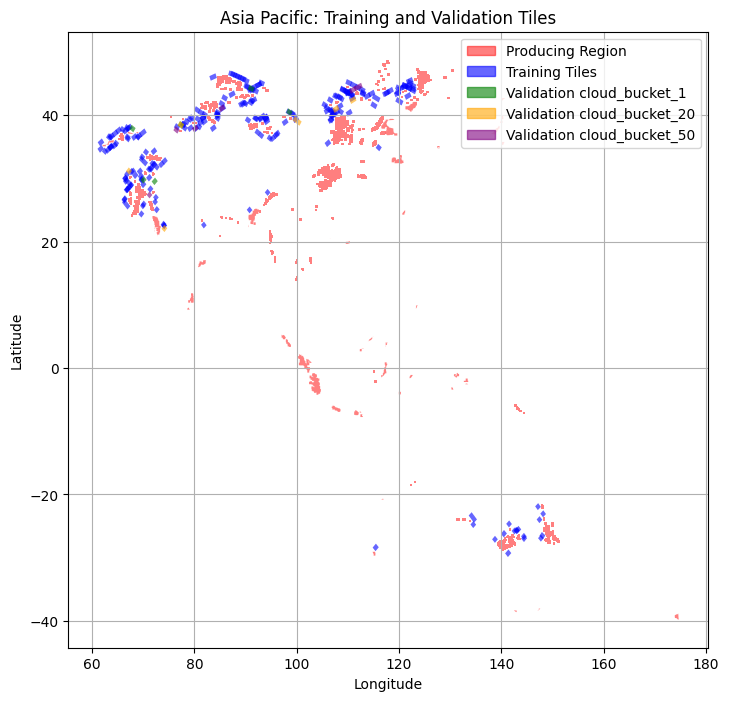

In [106]:
for region_name, training_tiles in training_tiles_by_region.items():
    cloud_bucket_tiles = validation_tiles_by_region[region_name]
    plot_region_tiles(training_tiles, cloud_bucket_tiles, producing_by_region, region_name)